In [4]:
# Template for the SMC competition for modeling neurons in the superior colliculus

import math
import numpy as np
import h5py

# Please download the file SCNeuronModelCompetition.mat from here.
# https://github.com/santacruzml/fall-17-scml-competition/releases/download/0.0-data/SCNeuronModelCompetition.mat

datafile = h5py.File('SCNeuronModelCompetition.mat')
movie = datafile.get('trainingmovie_mini') # movie for training
frhist = datafile.get('FRhist_tr') # firing rate histograms

# # a little normalization for the movie (assuming that the movie is 3D array)
# def normalize(inputmovie):
#     movie_mean = np.mean(inputmovie, axis=(0, 1, 2))
#     movie_std = np.std(inputmovie, axis=(0, 1, 2))
#     return (inputmovie - movie_mean) / movie_std

# movie_norm = normalize(movie)

# movief = np.array(movie_norm[:,:,(16*128):(80*128)])
# movief = movief.reshape((288,150,64,128))
# movief = np.expand_dims(movief,axis=4)

In [2]:
movie_norm = []

In [ ]:
movief = np.array(movie[:,:,(16*128):(80*128)],dtype='float32')
movief = movief.reshape((288,150,64,128))
movief = movief/255
movief = np.expand_dims(movief,axis=4)

In [ ]:
print(movief.dtype)
print(movief.shape)
print(frhist.shape)

In [ ]:
# frhist2 = frhist.astype(np.float32)
# frhist  = np.expand_dims(frhist,axis=3)
# print
frhist2 = np.array(frhist,dtype='float32')
frhist2 = np.expand_dims(frhist2,axis=3)
print(frhist2.shape)

In [ ]:
print(movie, movie.shape)
print(frhist.shape)

# 150 is the number of frames
# 12288 is the video pxiels,   
# 288 is the number of trials


import matplotlib.pyplot as plt
%matplotlib inline

# frame = np.array(movie_norm[50,120,:]).reshape((96,128))
# frame = np.array(movie[225,1,(0*128):(96*128)]).reshape((96,128))

# print(frame.shape)

plt.figure()
plt.imshow(np.squeeze(movief[225,1,:,:,:]),cmap='Greys_r',clim=(0,1))

# for ii in enumerate frame[:,10]:
#     print('{}:{} '.format(ii,frame[ii,10]))


# frame2 = np.array(movie[225,1,(16*128):(80*128)]).reshape((64,128))
# print(frame2.shape)
# plt.figure()
# plt.imshow(frame2,cmap='Greys_r',clim=(0,255))

In [ ]:
frame2 = np.array(movie[225,1,:]).reshape((96,128))

# print(frame2[:,60].shape)

for a in zip(np.arange(frame2[:,55].shape[0]), frame2[:,110]):
    print(a)
    
## the movie part is [16:80,:]

In [4]:
# here's the modeling part. I'll give just a starting point

import keras
# from keras.layers import LSTM, Activation, Dense, BatchNormalization
from keras.layers import ConvLSTM2D, Dense, BatchNormalization, Flatten, Reshape, MaxPooling3D

# It makes a 3-layer LSTM network with batch normalization on each layer.
# No dropout, regularization, convolution structures are used.
# As you see in the summary, most parameters go to the first weight matrix.



movie_chunk_length = movief.shape[1]
movie_pix = movief.shape[2]
nHidden = 100
nLayer = 3
nSCNeu = frhist.shape[2]
movie_i = 64
movie_j = 128
filtnum = 20

print(movie_i*movie_j*filtnum)


# from keras.models import Sequential
# from keras.layers.convolutional import Conv3D
# from keras.layers.convolutional_recurrent import n
# from keras.layers.normalization import BatchNormalization
# import numpy as np
# import pylab as plt

# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.

model = keras.models.Sequential()
model.add(ConvLSTM2D(filters=filtnum, kernel_size=(3, 3),
                   input_shape=(150, 64, 128, 1),
                   padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 4, 4), padding='valid'))
# model.add(ConvLSTM2D(filters=filtnum, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=None, padding='valid'))
# model.add(ConvLSTM2D(filters=filtnum, kernel_size=(3, 3),
#                    padding='same', return_sequences=True))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(1, 2, 2), strides=None, padding='valid'))
model.add(Reshape((150,-1)))
# # model.add(Dense(1000, activation='relu'))
model.add(Dense(nSCNeu, activation='softplus'))
model.compile(loss='poisson', optimizer='adadelta')











# model = keras.models.Sequential()
# model.add(LSTM(nHidden, input_shape=(movie_chunk_length, movie_pix), return_sequences=True, implementation=2))

# for _ in range(nLayer-1):
#     model.add(BatchNormalization(momentum=0))
#     model.add(Activation('relu'))
#     model.add(LSTM(nHidden, return_sequences=True))
    
# model.add(BatchNormalization(momentum=0))
# model.add(Activation('linear'))
# model.add(Dense(nSCNeu))
# model.add(Activation('softplus'))
# adamopt = keras.optimizers.Adam(lr = 0.001, decay = 1e-7)

# # Please make sure to use Poisson likelihood function for the loss function
# model.compile(optimizer=adamopt, loss='poisson')
model.summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(movief, frhist, epochs=10, batch_size=8, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

163840
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 150, 64, 128, 20)  15200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 64, 128, 20)  80        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 150, 16, 32, 20)   0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 150, 10240)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 150, 54)           553014    
Total params: 568,294
Trainable params: 568,254
Non-trainable params: 40
_________________________________________________________________
Train on 230 samples, validate on 58 samples
Epoch 1/10
230/230 [==============================] - 34263s 149s/step - loss: 0.69

In [5]:
model.save('/Users/dclark/work/scml_model_1.h5')

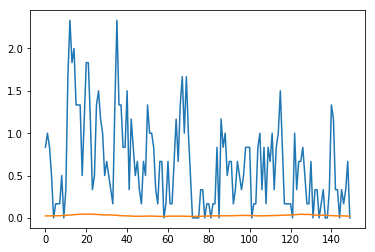

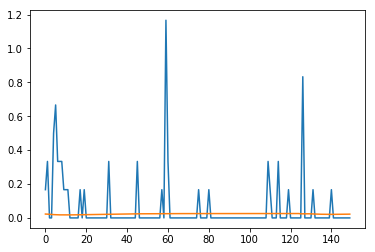

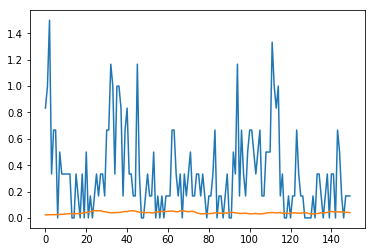

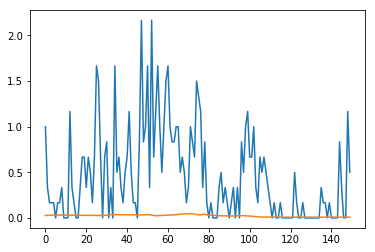

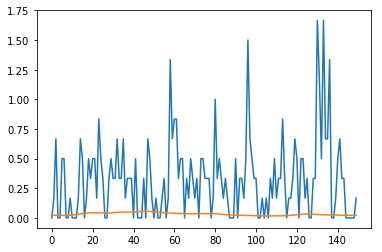

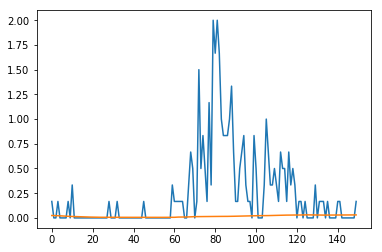

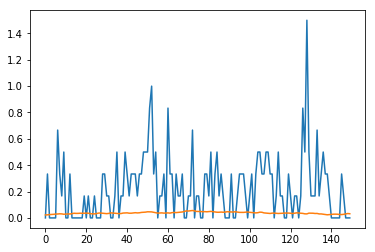

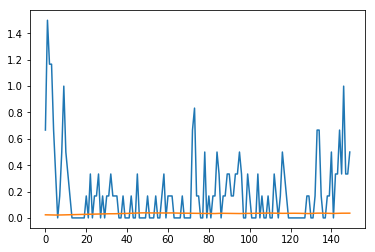

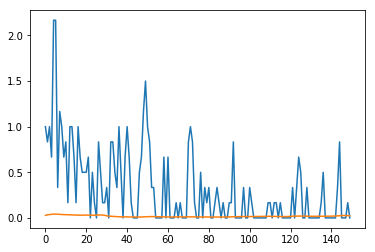

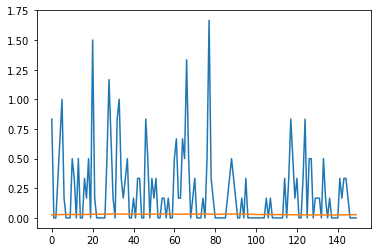

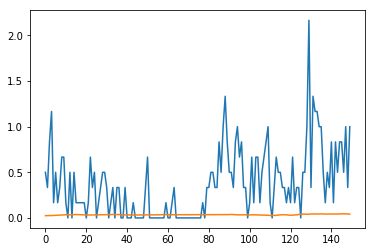

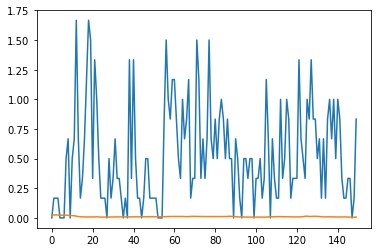

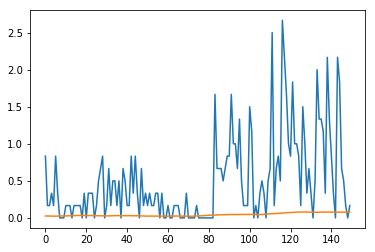

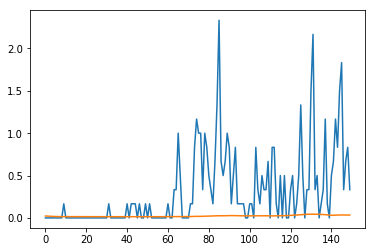

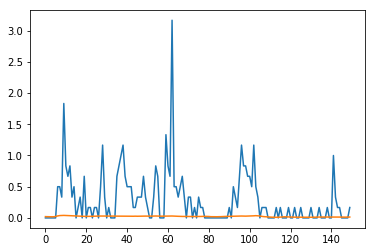

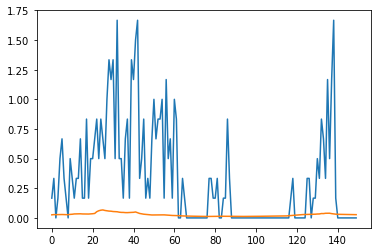

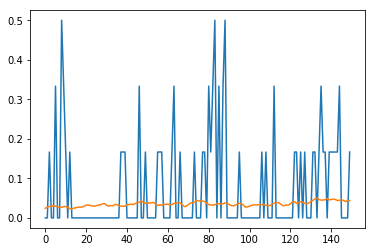

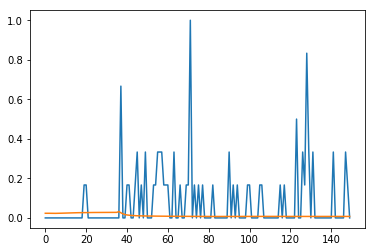

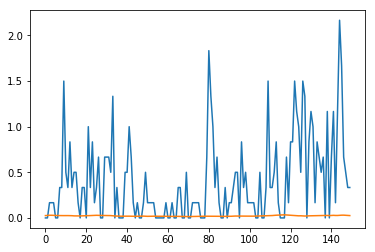

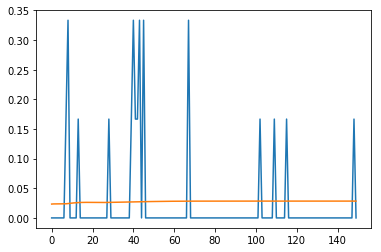

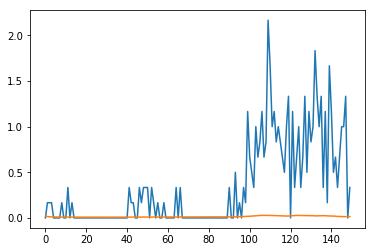

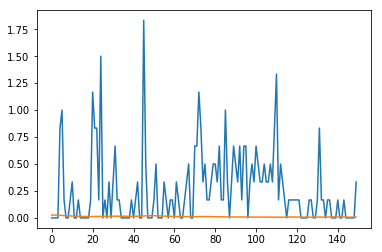

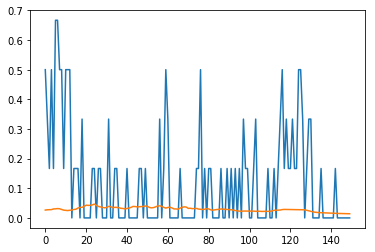

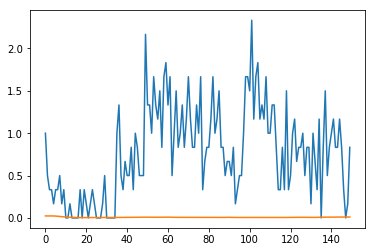

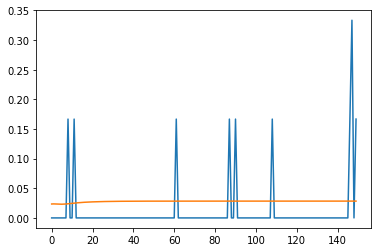

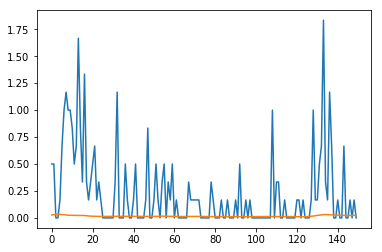

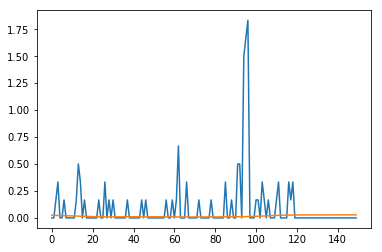

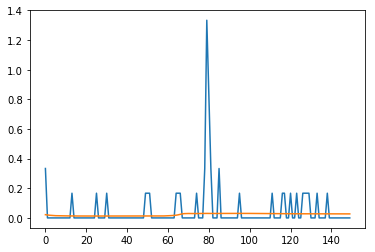

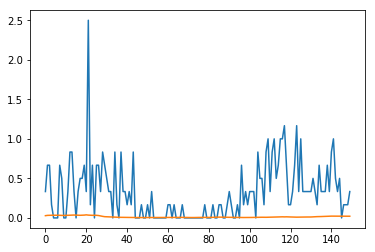

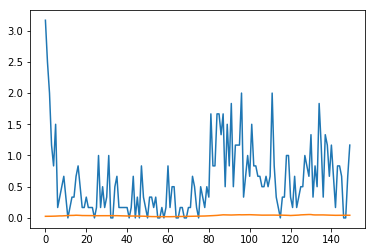

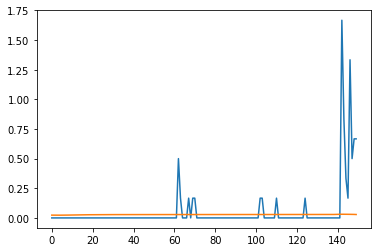

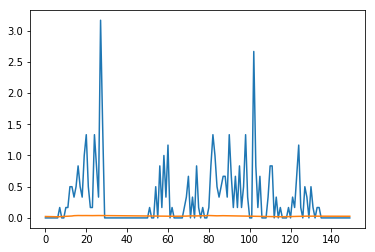

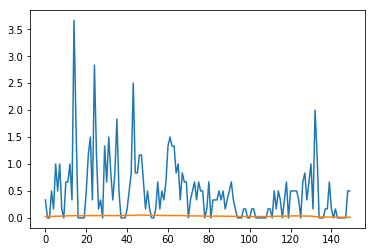

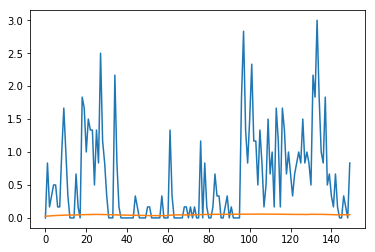

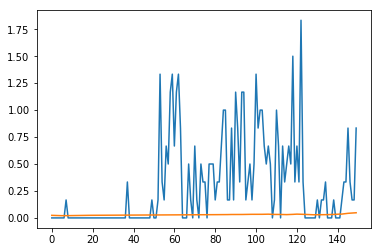

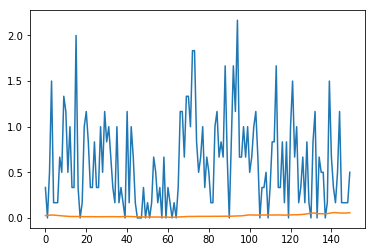

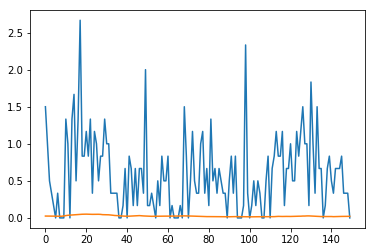

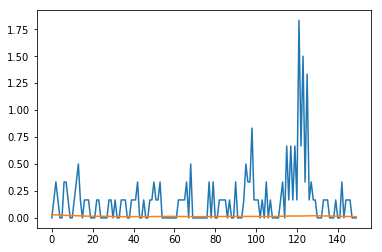

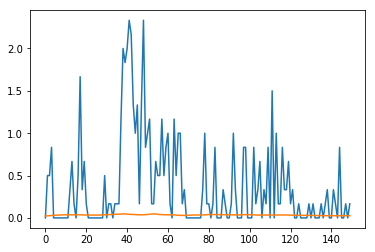

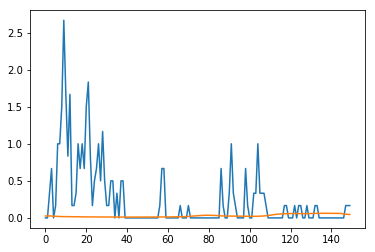

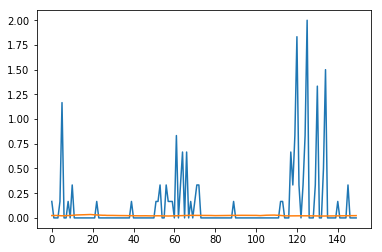

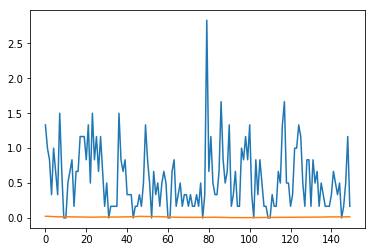

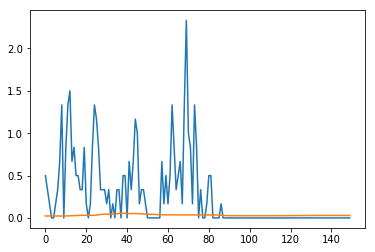

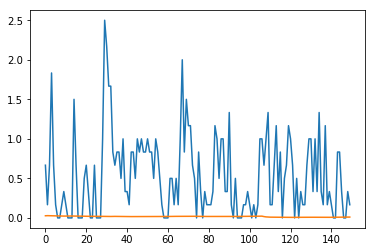

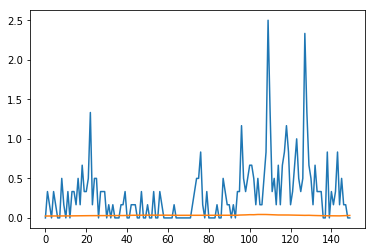

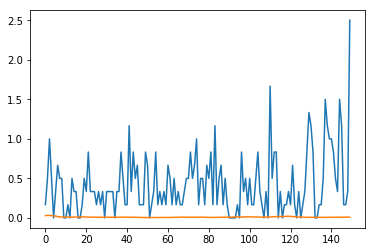

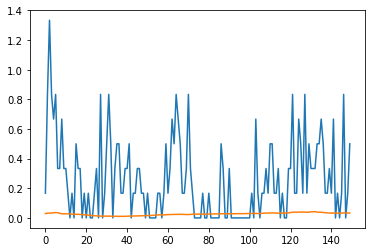

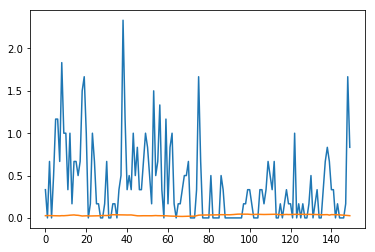

In [6]:
# check if it does a good job in the training dataset
%matplotlib inline
import matplotlib.pyplot as plt

output = model.predict(movief)

for m in range(0, 48):
    n=31
    # plot the average of 6 trials of the same movie
    plt.plot(np.mean(frhist[(m*6):(m+1)*6, :, n], axis=(0)))
    
    # plot the output of the network
    plt.plot(output[m*6,:,n])
    plt.show()
    # last 10 movies should be the validation dataset

In [ ]:
movief3 = np.expand_dims(movief.reshape((288,150,64,128)),axis=4)
movief3.shape

%matplotlib inline
plt.figure(5)
plt.imshow(np.squeeze(movief3[190,120,:,:,:]),cmap='Greys_r',clim=(0,1))

In [ ]:
def generate_movies(n_samples=20, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1),
                              dtype=np.float)

    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)

        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            # Direction of motion
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w,
                             y_shift - w: y_shift + w, 0] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t,
                                 x_shift - w - 1: x_shift + w + 1,
                                 y_shift - w - 1: y_shift + w + 1,
                                 0] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w,
                               y_shift - w: y_shift + w, 0] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

# Train the network
noisy_movies, shifted_movies = generate_movies(n_samples=20)

In [ ]:
noisy_movies.shape

In [ ]:
a = np.zeros((5,5),dtype='float')
print(a.dtype)
b = np.expand_dims(a,axis=2)
print(b.shape)
print(b)

c = np.zeros((2, 3, 2, 2, 1))
print(c.shape)

In [18]:
import pydot
import graphviz
from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)  


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 150, 64, 128, 20)  15200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 64, 128, 20)  80        
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 150, 16, 32, 20)   0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 150, 10240)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 150, 54)           553014    
Total params: 568,294
Trainable params: 568,254
Non-trainable params: 40
_________________________________________________________________


In [8]:
import math

import numpy as np
import h5py
datafile = h5py.File('SCNeuronModelCompetition.mat')
movie = datafile.get('trainingmovie_mini') # movie for training
frhist = datafile.get('FRhist_tr') # firing rate histograms






OSError: Unable to create file (unable to open file: name = 'SCNeuronModelCompetition.mat', errno = 17, error message = 'File exists', flags = 15, o_flags = a02)

In [3]:
!pwd

/Users/dclark/work/fall-17-scml-competition


In [4]:
!ls


LICENSE
README.md
SCNeuronModelCompetition.mat
__pycache__
conv_lstm_mobilenet.ipynb
mobilenet_copy.py
requirements.txt
scml-SuperiorColliculusCompetition.ipynb
scml-SuperiorColliculusCompetition_scratch.ipynb
simple_scratch.ipynb
